In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from loguru import logger
import seaborn as sns

In [2]:
data_dir = Path("../data")

coconut_df = pd.read_csv(data_dir / "processed" / "coconut.csv")
dyes_df = pd.read_csv(data_dir / "processed" / "dyes.csv")
zinc_df = pd.read_csv(data_dir / "processed" / "zinc.csv")

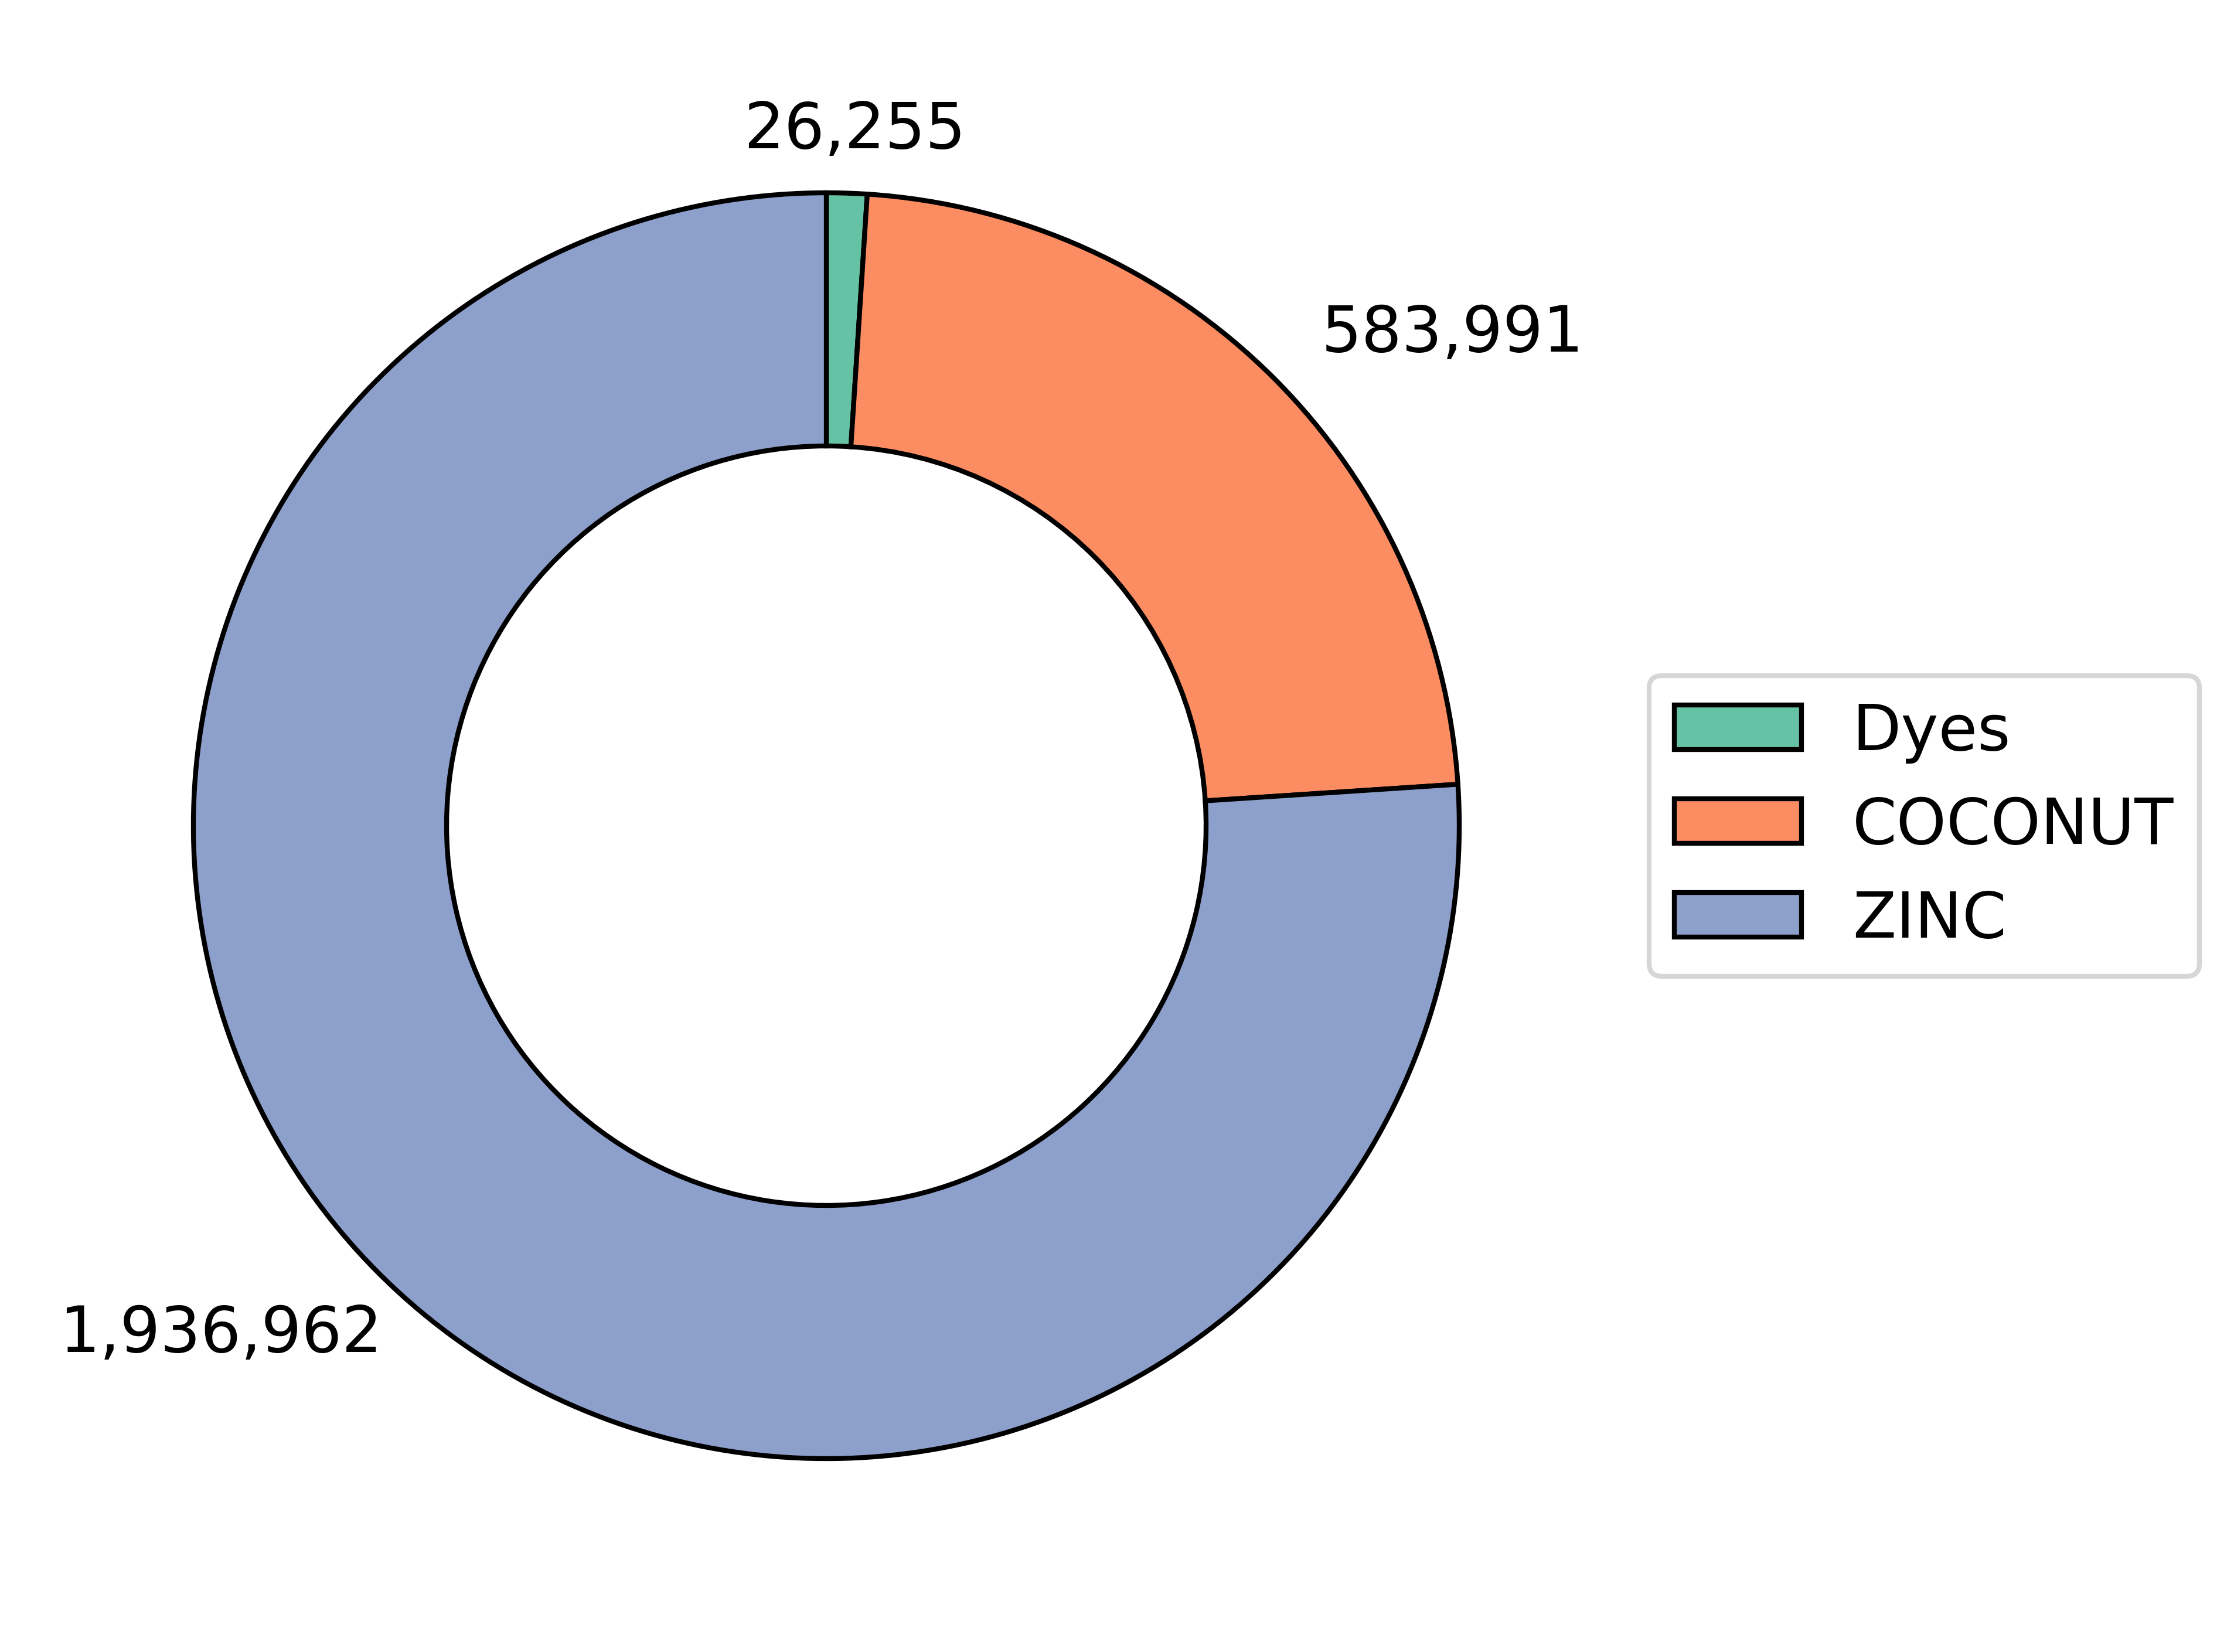

In [11]:
def plot_dataset_size_doughnut():
    """改进版：绘制数据集大小的环形图（数量标签，微小扇区处理）"""

    # 数据集大小
    sizes = [len(dyes_df), len(coconut_df), len(zinc_df)]
    labels = ["Dyes", "COCONUT", "ZINC"]
    colors = plt.cm.Set2.colors

    # 将很小的部分设为微小间隔，避免被忽略
    total = sum(sizes)
    sizes_adj = [max(s, total * 0.005) for s in sizes]  # 至少占0.5%

    plt.figure(dpi=600)

    wedges, texts = plt.pie(
        sizes_adj,
        labels=None,     # 先不打label
        colors=colors,
        startangle=90,
        counterclock=False,
        wedgeprops={'width': 0.4, 'edgecolor': 'black'}  # width控制环形
    )

    # 在环外手动标数量
    for i, (wedge, size) in enumerate(zip(wedges, sizes)):
        angle = (wedge.theta2 + wedge.theta1) / 2
        x = 1.4 * np.cos(np.deg2rad(angle))
        y = 1.1 * np.sin(np.deg2rad(angle))
        plt.text(x, y, f"{size:,}", ha='center', va='center', fontsize=13)

    # 手动添加图例
    plt.legend(wedges, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=13)

    plt.tight_layout()
    plt.show()

plot_dataset_size_doughnut()

In [64]:
logger.info(f"original length: Dyes: {len(dyes_df)}, Coconut: {len(coconut_df)}, Zinc: {len(zinc_df)}")
min_len = min(len(dyes_df), len(coconut_df), len(zinc_df))

# sample to min_len
dyes_df = dyes_df.sample(min_len, random_state=42)
coconut_df = coconut_df.sample(min_len, random_state=42)
zinc_df = zinc_df.sample(min_len, random_state=42)
logger.info(f"sampled length: Dyes: {len(dyes_df)}, Coconut: {len(coconut_df)}, Zinc: {len(zinc_df)}")

2025-04-19 16:03:33.142 | INFO     | __main__:<module>:1 - original length: Dyes: 26255, Coconut: 583991, Zinc: 1936962
2025-04-19 16:03:33.194 | INFO     | __main__:<module>:8 - sampled length: Dyes: 26255, Coconut: 26255, Zinc: 26255


In [65]:
for col_name in ["MW","ALOGP","HBA","HBD","PSA","ROTB","AROM","ALERTS"]:
    if col_name in ["ALOGP","MW","PSA"]:
        dyes_df[col_name] = dyes_df[col_name].astype(float)
        coconut_df[col_name] = coconut_df[col_name].astype(float)
        zinc_df[col_name] = zinc_df[col_name].astype(float)
    else:
        dyes_df[col_name] = dyes_df[col_name].astype(int)
        coconut_df[col_name] = coconut_df[col_name].astype(int)
        zinc_df[col_name] = zinc_df[col_name].astype(int)

In [66]:
def plot_distribution(
    df1: pd.DataFrame,
    df2: pd.DataFrame,
    df3: pd.DataFrame,
    label1: str,
    label2: str,
    label3: str,
    col_name: str,
):
    """绘制三个数据集的分布直方图，并叠加核密度曲线"""
    
    plt.figure(figsize=(6, 4), dpi=600)

    if col_name == "MW":
        bins = range(0, 1251, 20)
        plt.xlim(0, 1251)
    elif col_name == "PSA":
        bins = range(0, 350, 8)
        plt.xlim(0, 350)
    elif col_name == "ALOGP":
        bins = np.arange(0, 12.5, 0.25)
        plt.xlim(0, 12)
        plt.xticks(range(0, 13, 1))
    else:
        bins = range(0, 20)  # 默认小数范围，比如HBA,HBD,ALOGP等
        plt.xlim(0, 15)
    # 统一颜色设置
    colors = plt.cm.Set2.colors
    
    # 绘制直方图（注意先绘背景）
    plt.hist(df1[col_name].dropna(), bins=bins, alpha=0.7, label=label1, 
             edgecolor="black", color=colors[0], density=True)
    plt.hist(df2[col_name].dropna(), bins=bins, alpha=0.7, label=label2, 
             edgecolor="black", color=colors[1], density=True)
    plt.hist(df3[col_name].dropna(), bins=bins, alpha=0.7, label=label3, 
             edgecolor="black", color=colors[2], density=True)



    # 绘制对应 KDE 曲线
    sns.kdeplot(df1[col_name].dropna(), color=colors[0], linewidth=2, alpha=1)
    sns.kdeplot(df2[col_name].dropna(), color=colors[1], linewidth=2, alpha=1)
    sns.kdeplot(df3[col_name].dropna(), color=colors[2], linewidth=2, alpha=1)



    plt.xlabel(col_name)
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

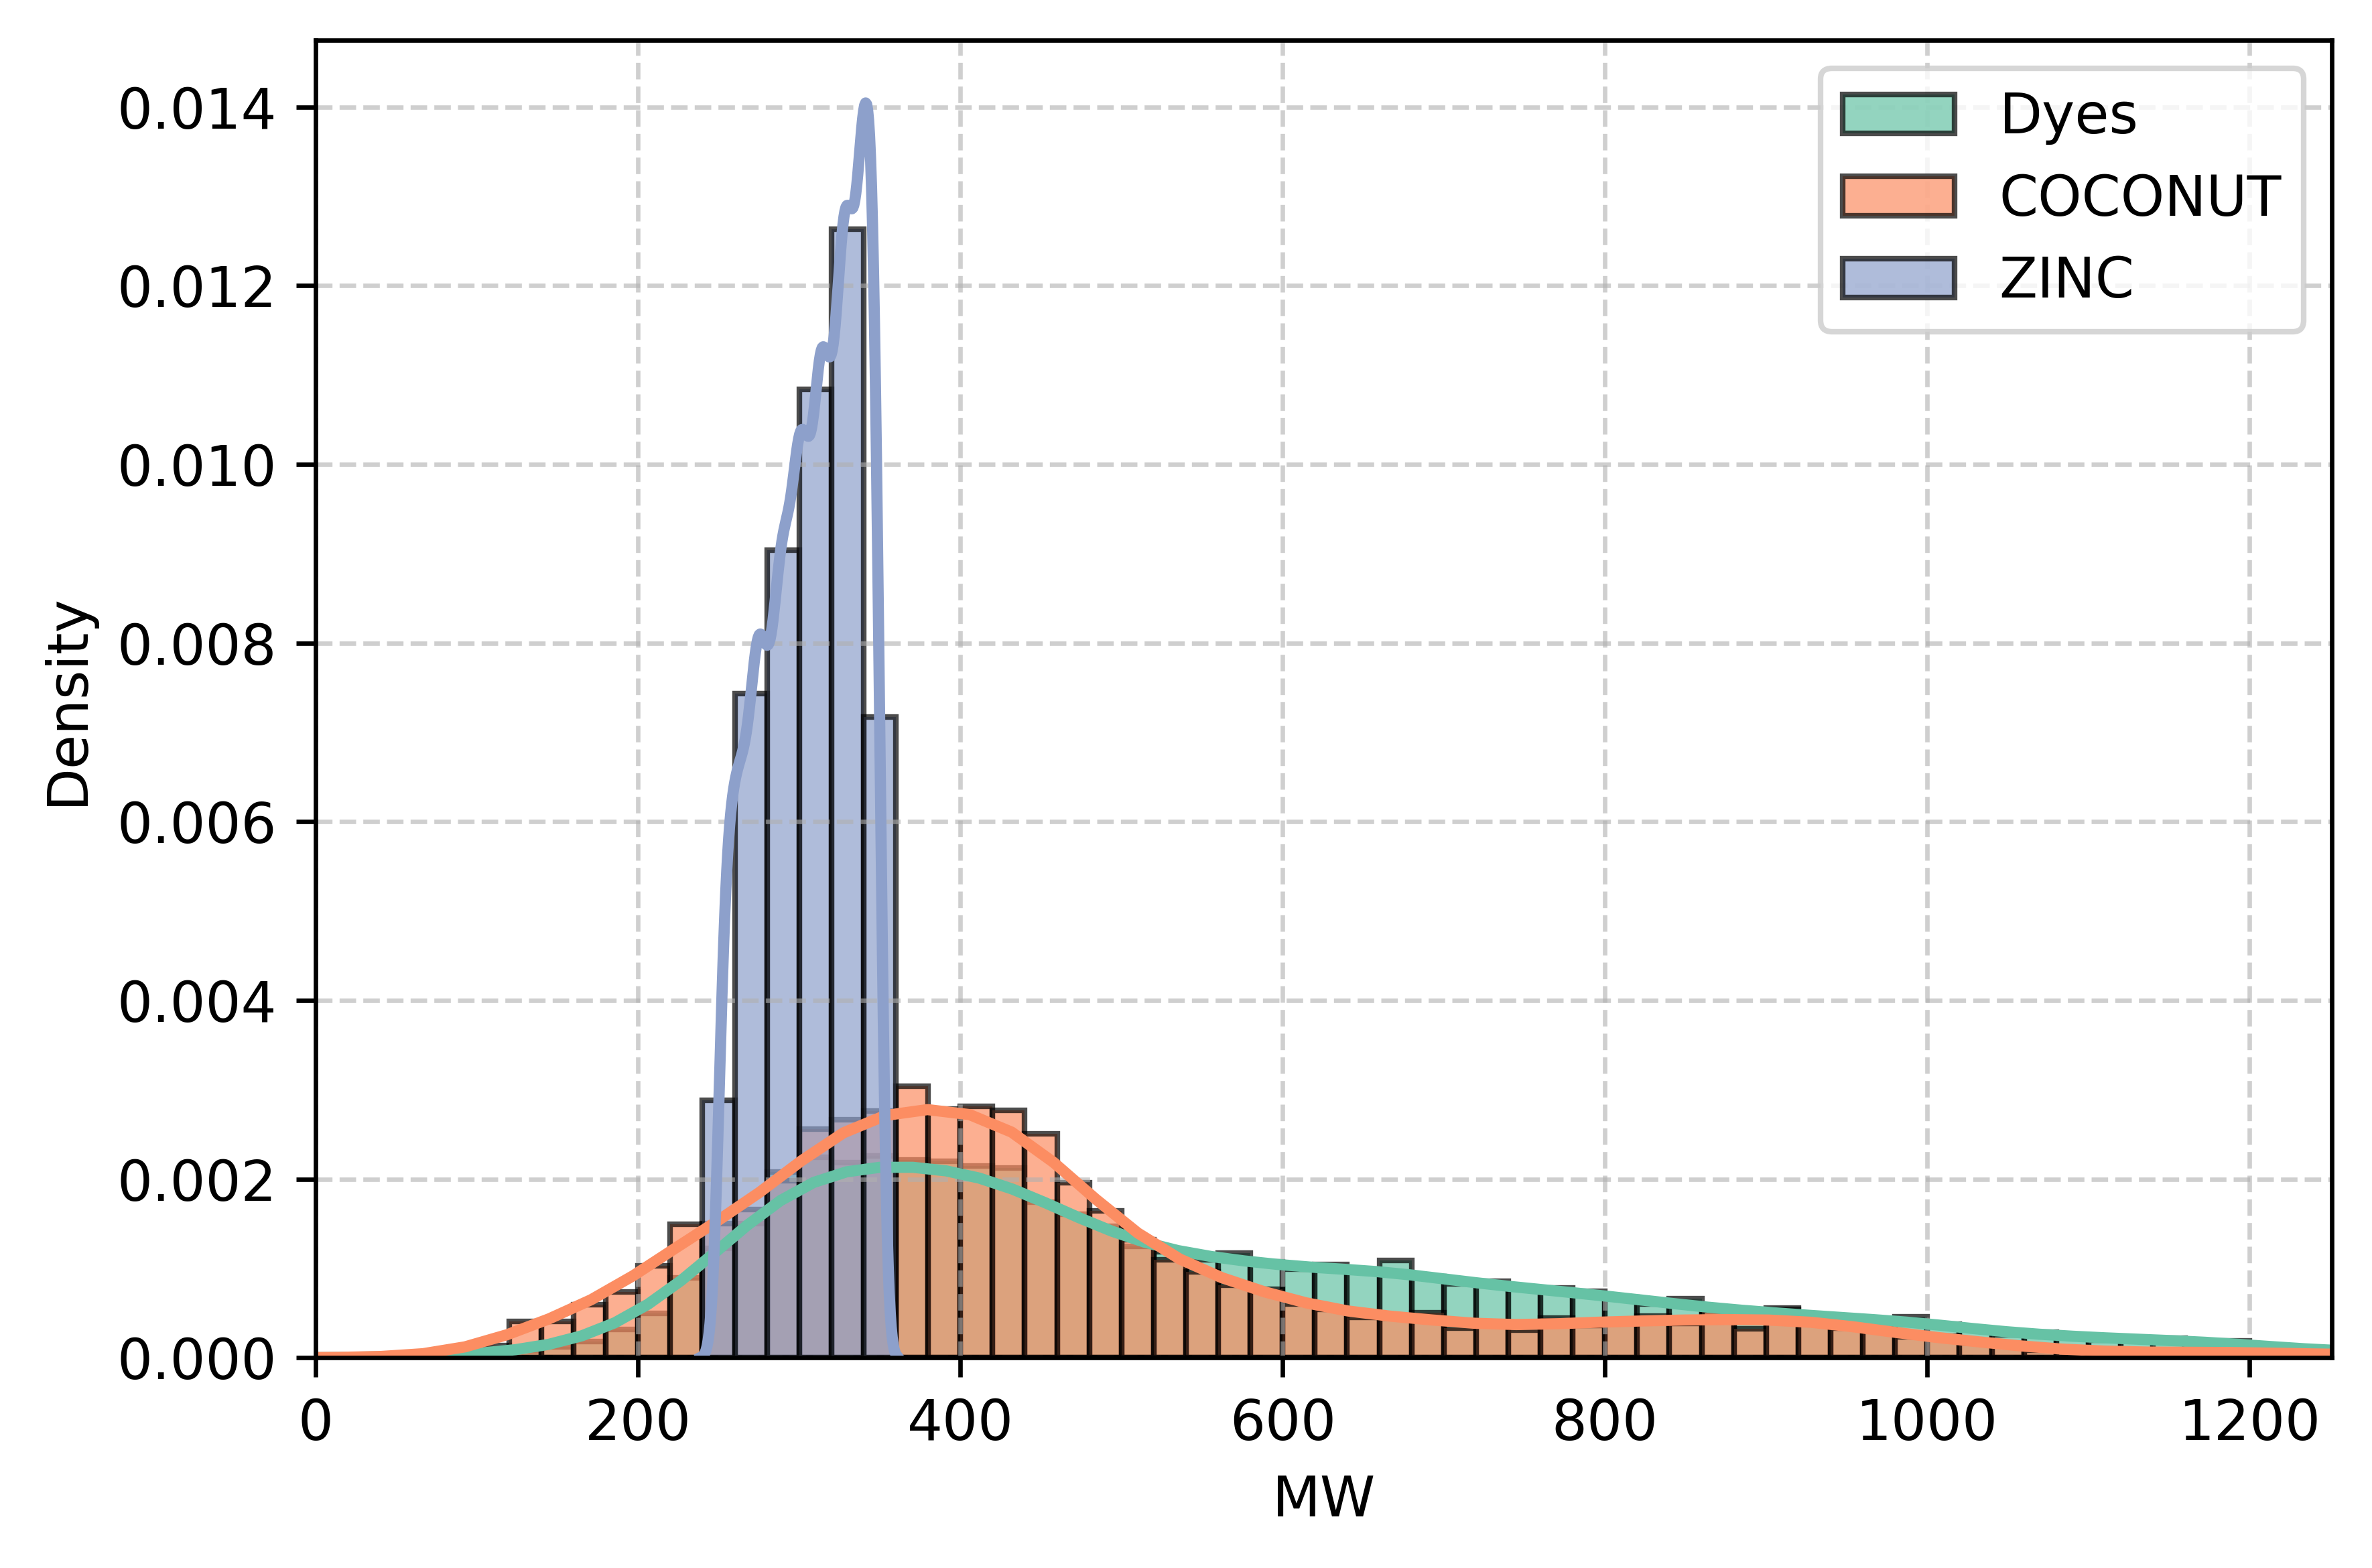

In [67]:
plot_distribution(dyes_df, coconut_df, zinc_df, "Dyes", "COCONUT", "ZINC", "MW")

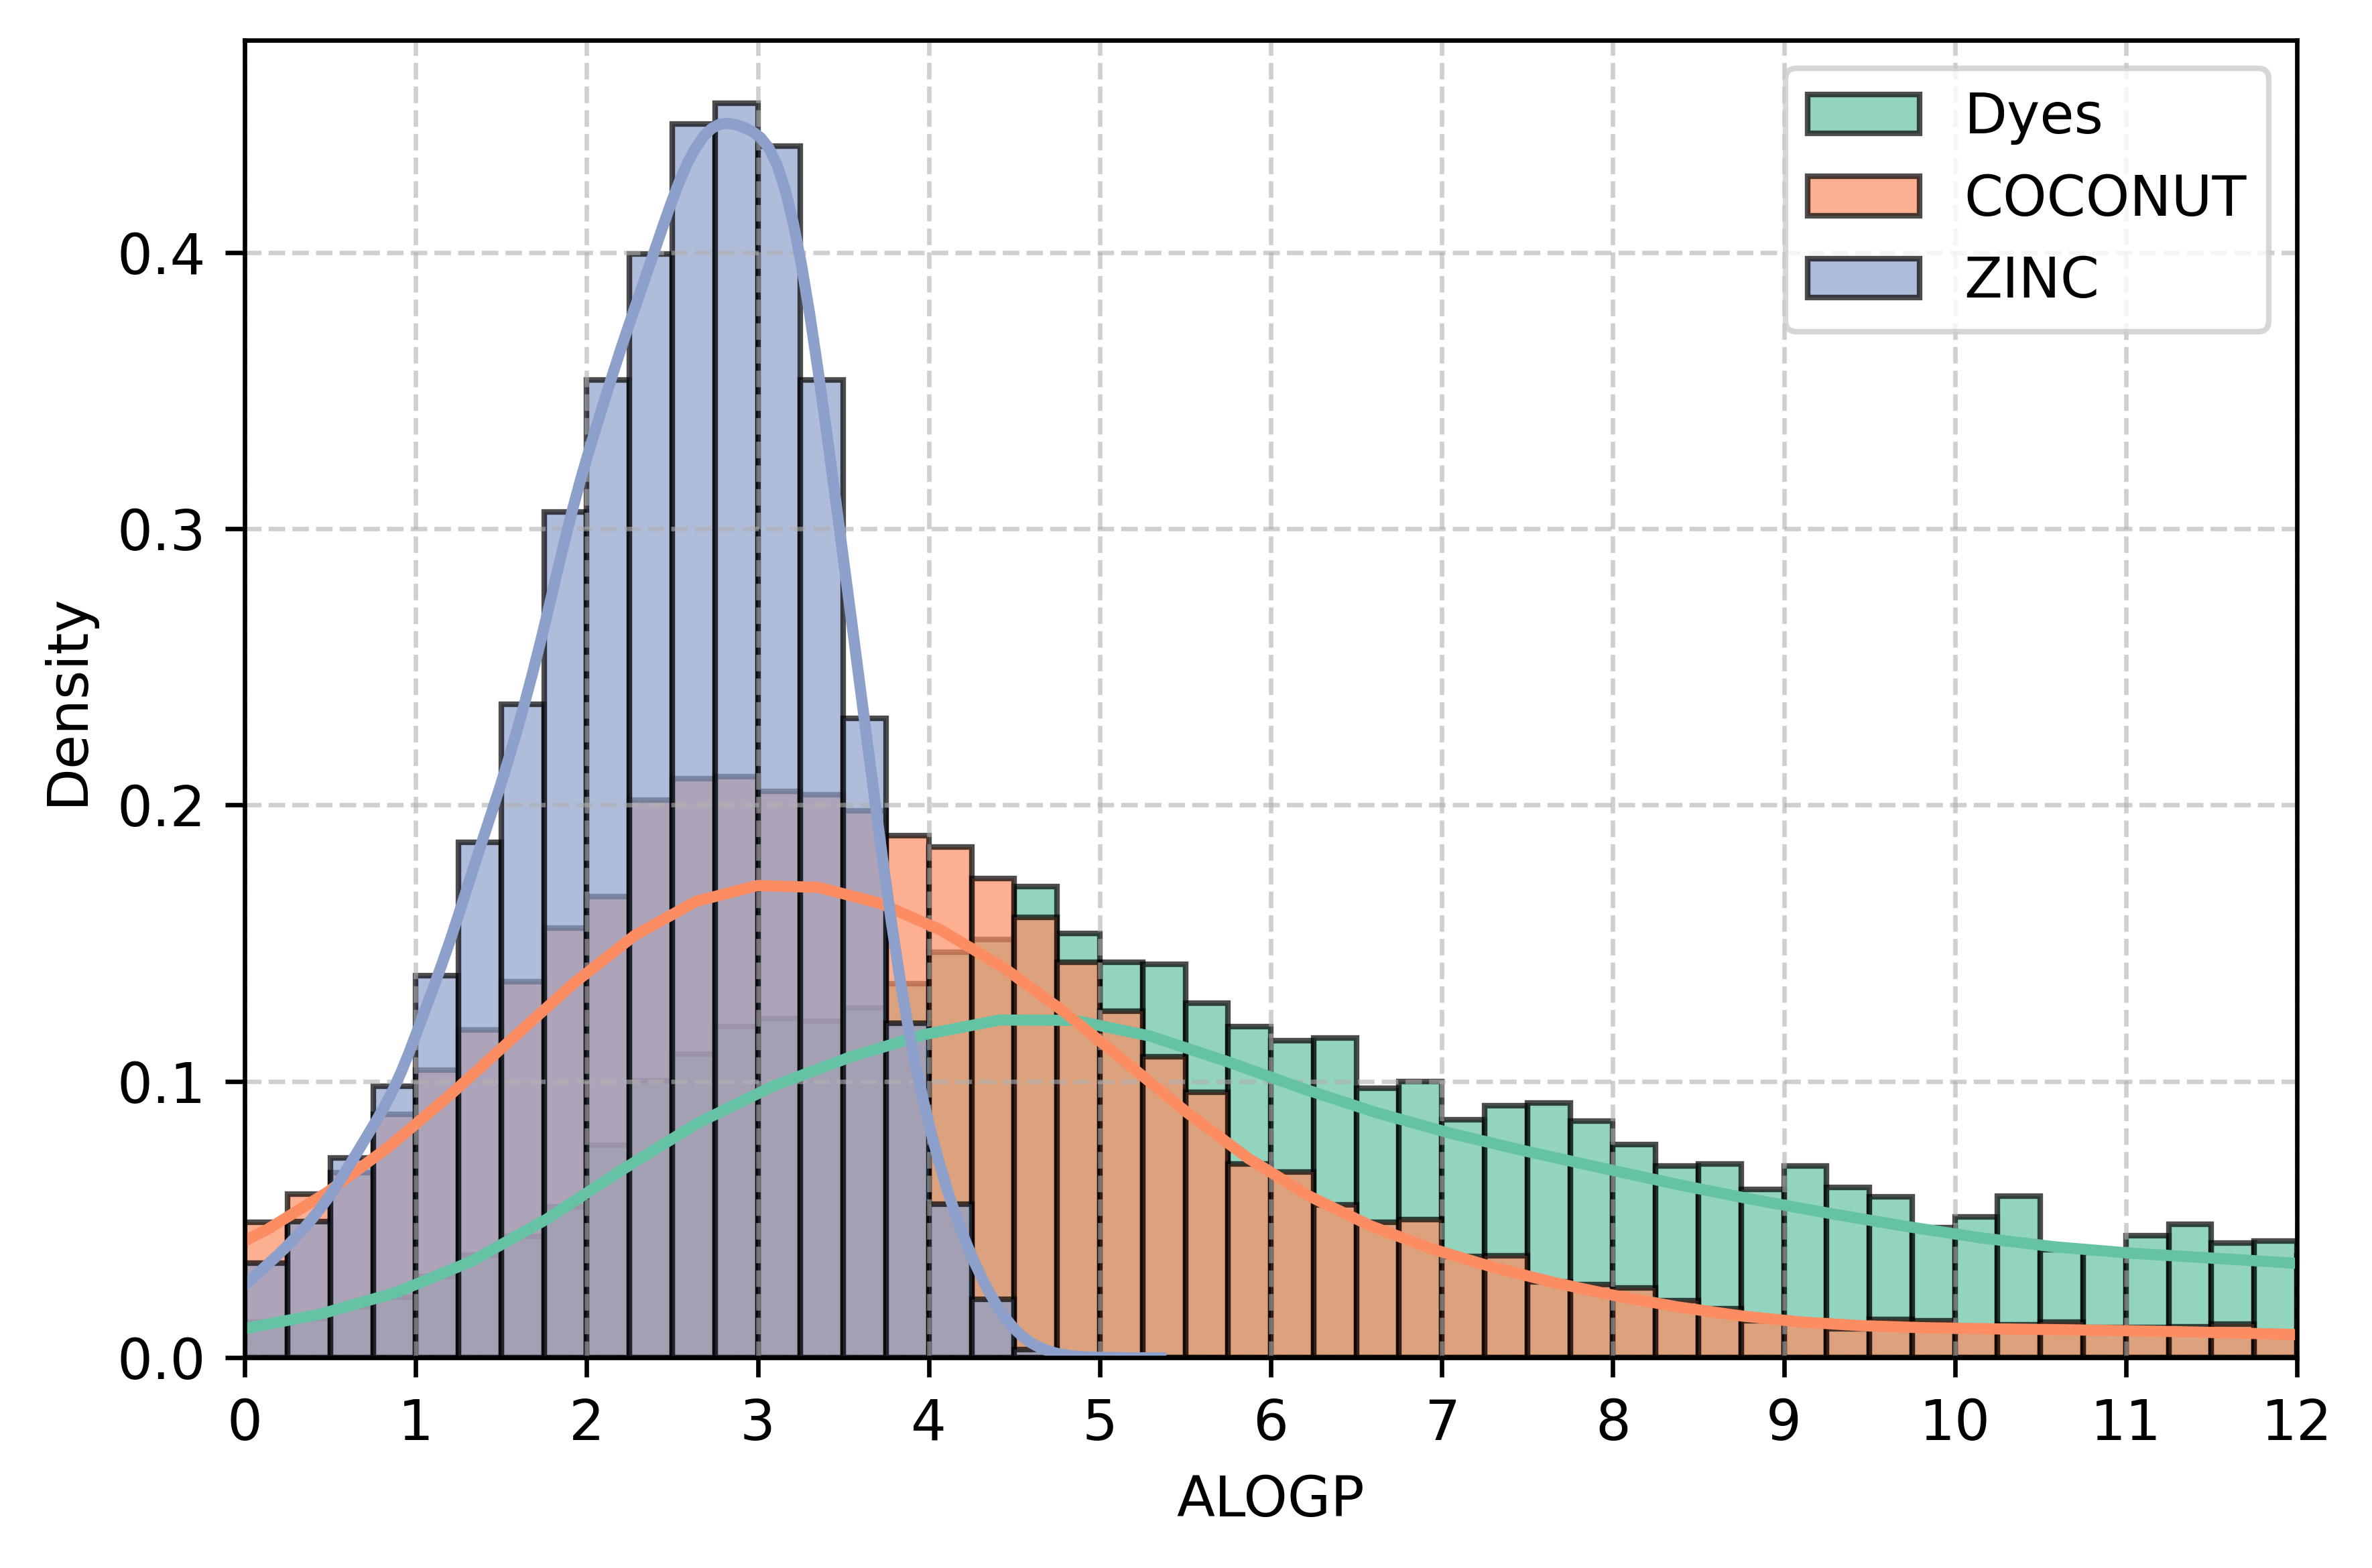

In [68]:
plot_distribution(dyes_df, coconut_df, zinc_df, "Dyes", "COCONUT", "ZINC", "ALOGP")

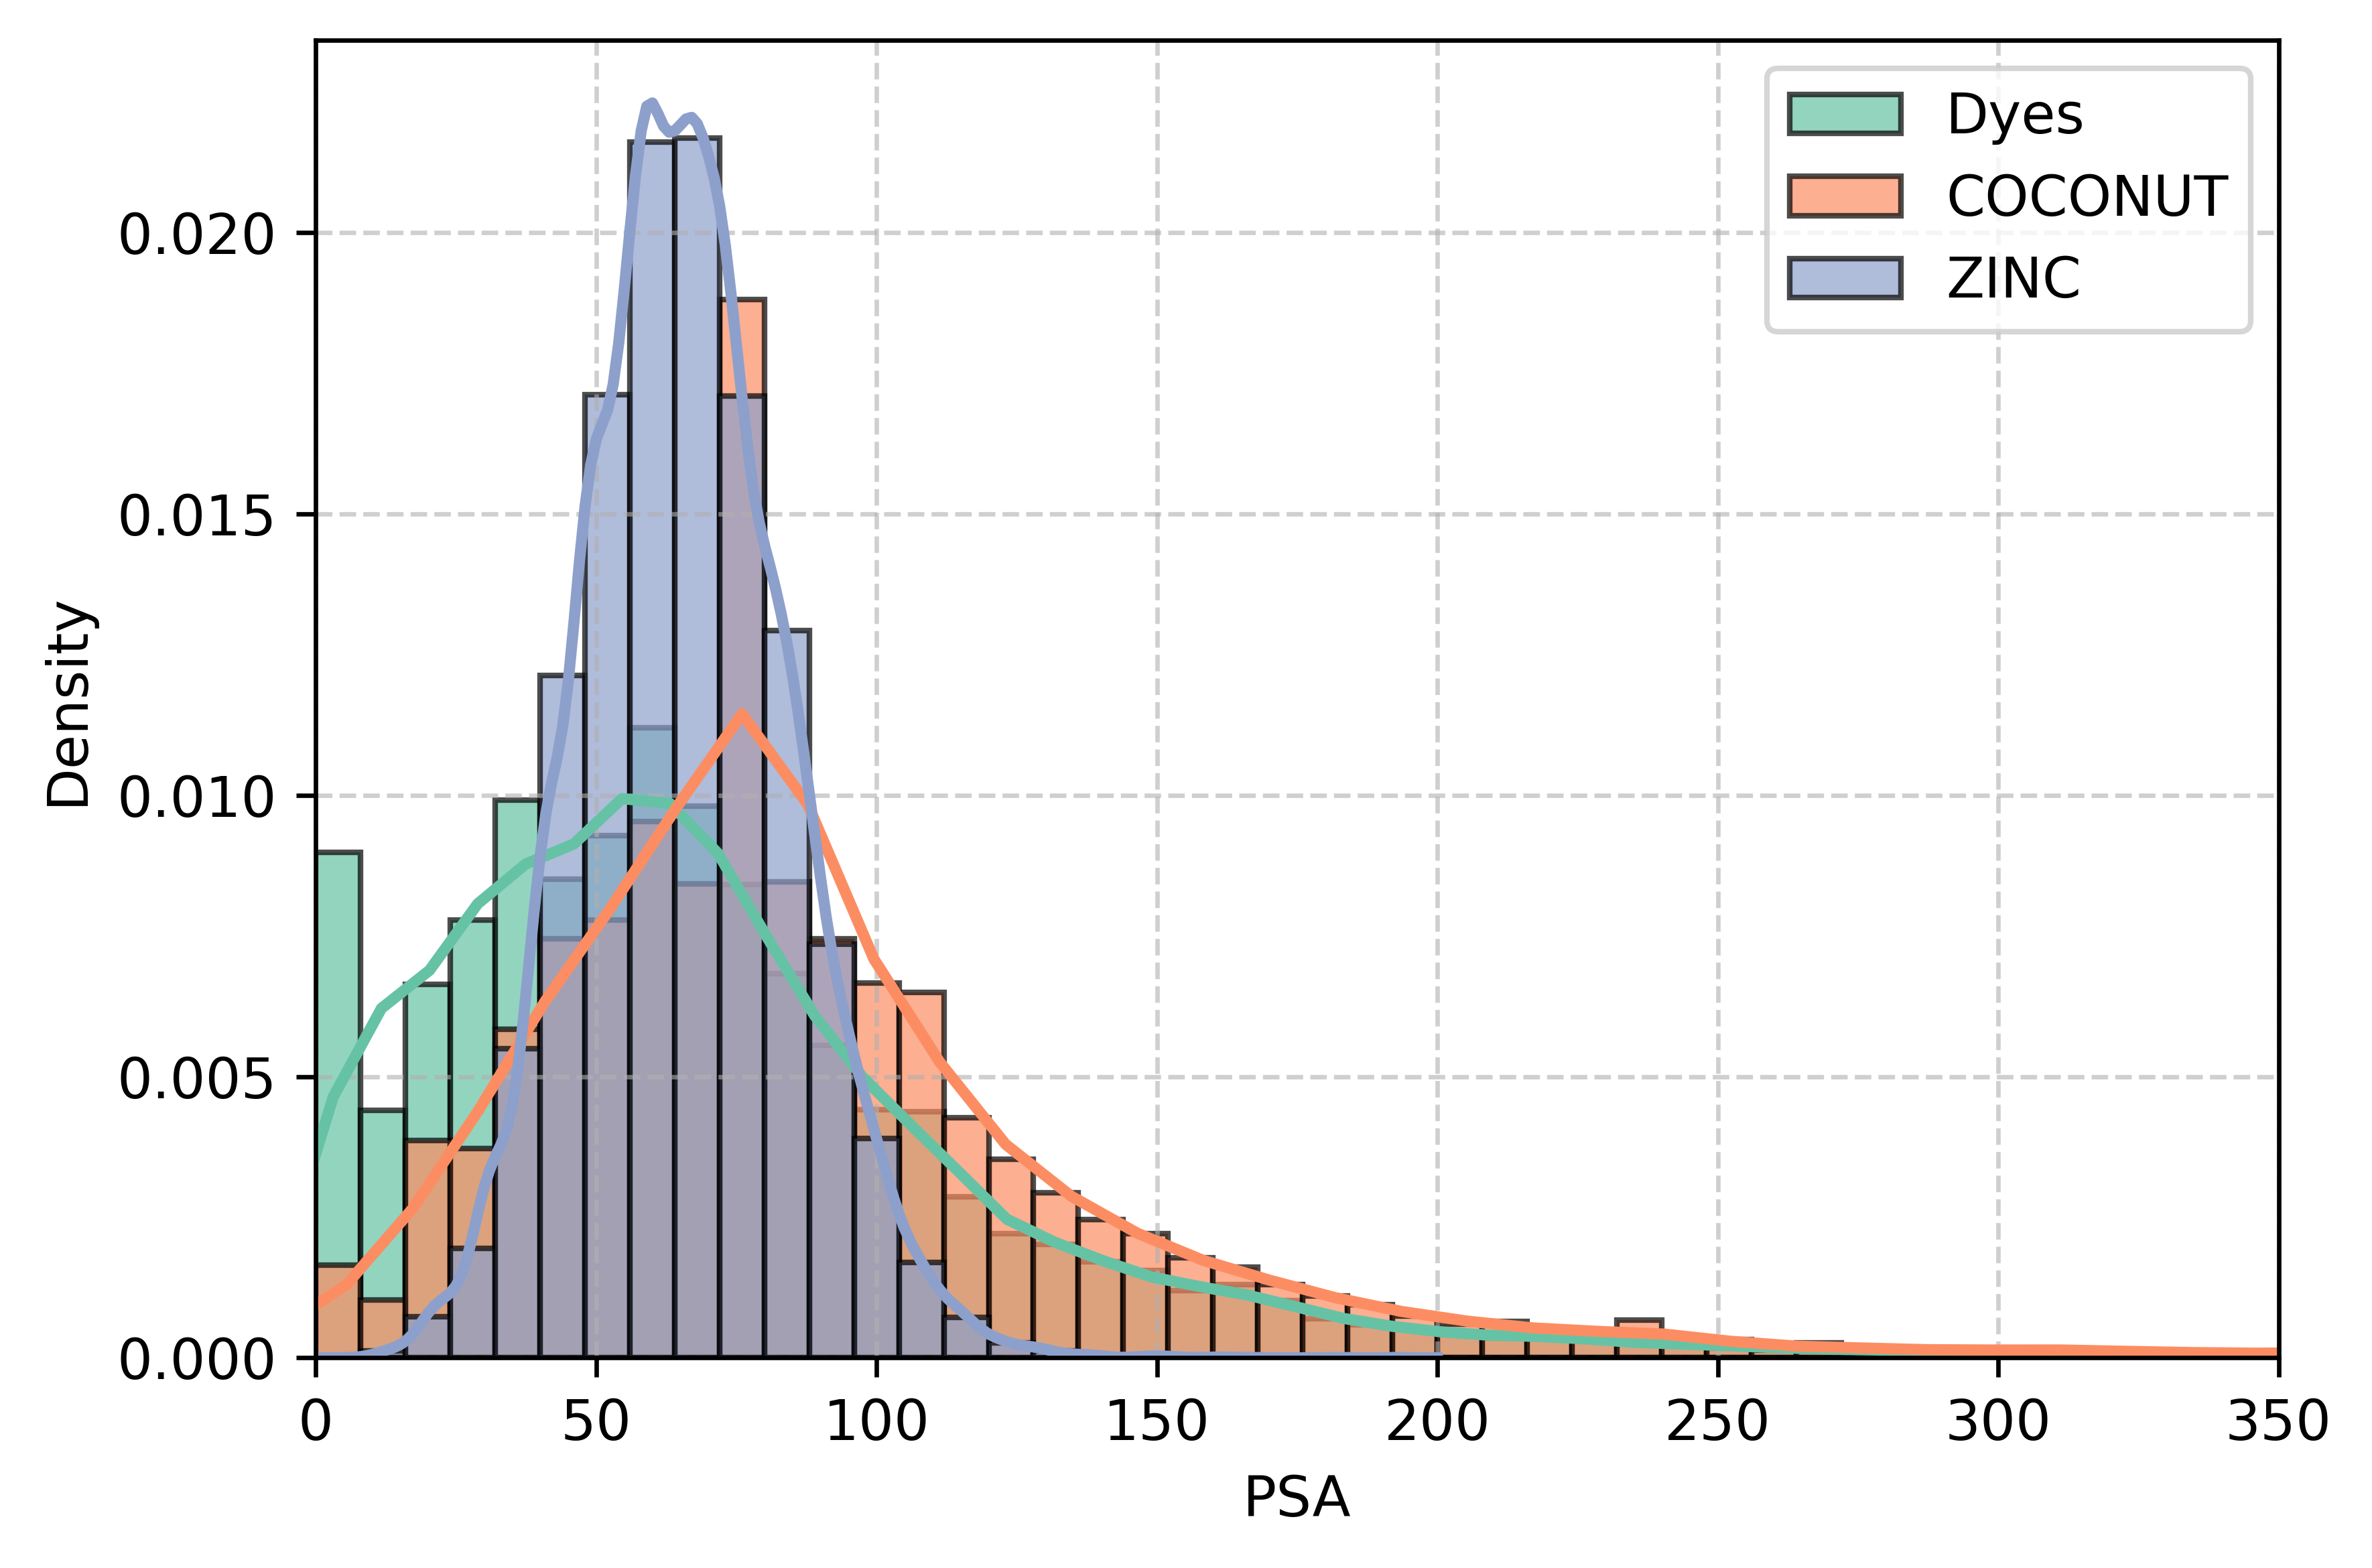

In [69]:
plot_distribution(dyes_df, coconut_df, zinc_df, "Dyes", "COCONUT", "ZINC", "PSA")

In [76]:
def plot_discrete_distribution(
    df1: pd.DataFrame,
    df2: pd.DataFrame,
    df3: pd.DataFrame,
    label1: str,
    label2: str,
    label3: str,
    col_name: str,
):
    """正确版：绘制三个数据集的离散变量并排柱状图"""

    plt.figure(figsize=(6, 4), dpi=600)

    colors = plt.cm.Set2.colors

    # 分别统计（小型统计，不耗时）
    count1 = df1[col_name].dropna().value_counts().sort_index()
    count2 = df2[col_name].dropna().value_counts().sort_index()
    count3 = df3[col_name].dropna().value_counts().sort_index()

    # 全部出现过的x值（并排保证x对齐）
    all_x = sorted(set(count1.index).union(count2.index).union(count3.index))
    x = np.arange(len(all_x))

    # 每组的y高度
    y1 = [count1.get(i, 0) for i in all_x]
    y2 = [count2.get(i, 0) for i in all_x]
    y3 = [count3.get(i, 0) for i in all_x]

    # 设置柱子的宽度和偏移
    total_width = 0.8
    single_width = total_width / 3

    plt.bar(x - single_width, y1, width=single_width, color=colors[0], label=label1, edgecolor="black", alpha=0.8)
    plt.bar(x,               y2, width=single_width, color=colors[1], label=label2, edgecolor="black", alpha=0.8)
    plt.bar(x + single_width, y3, width=single_width, color=colors[2], label=label3, edgecolor="black", alpha=0.8)

    # x轴设置
    plt.xticks(x, all_x)
    plt.xlabel(col_name)
    plt.ylabel("Count")

    # 关键！！你要的xlim
    if col_name == "HBA":
        plt.xlim(-0.5, 15.5)
    elif col_name == "HBD":
        plt.xlim(-0.5, 7.5)
    elif col_name == "ALERTS":
        plt.xlim(-0.5, 6.5)
    elif col_name == "ROTB":
        plt.xlim(-0.5, 15.5)
    elif col_name == "AROM":
        plt.xlim(-0.5, 11.5)

    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6, axis="y")
    plt.tight_layout()
    plt.show()

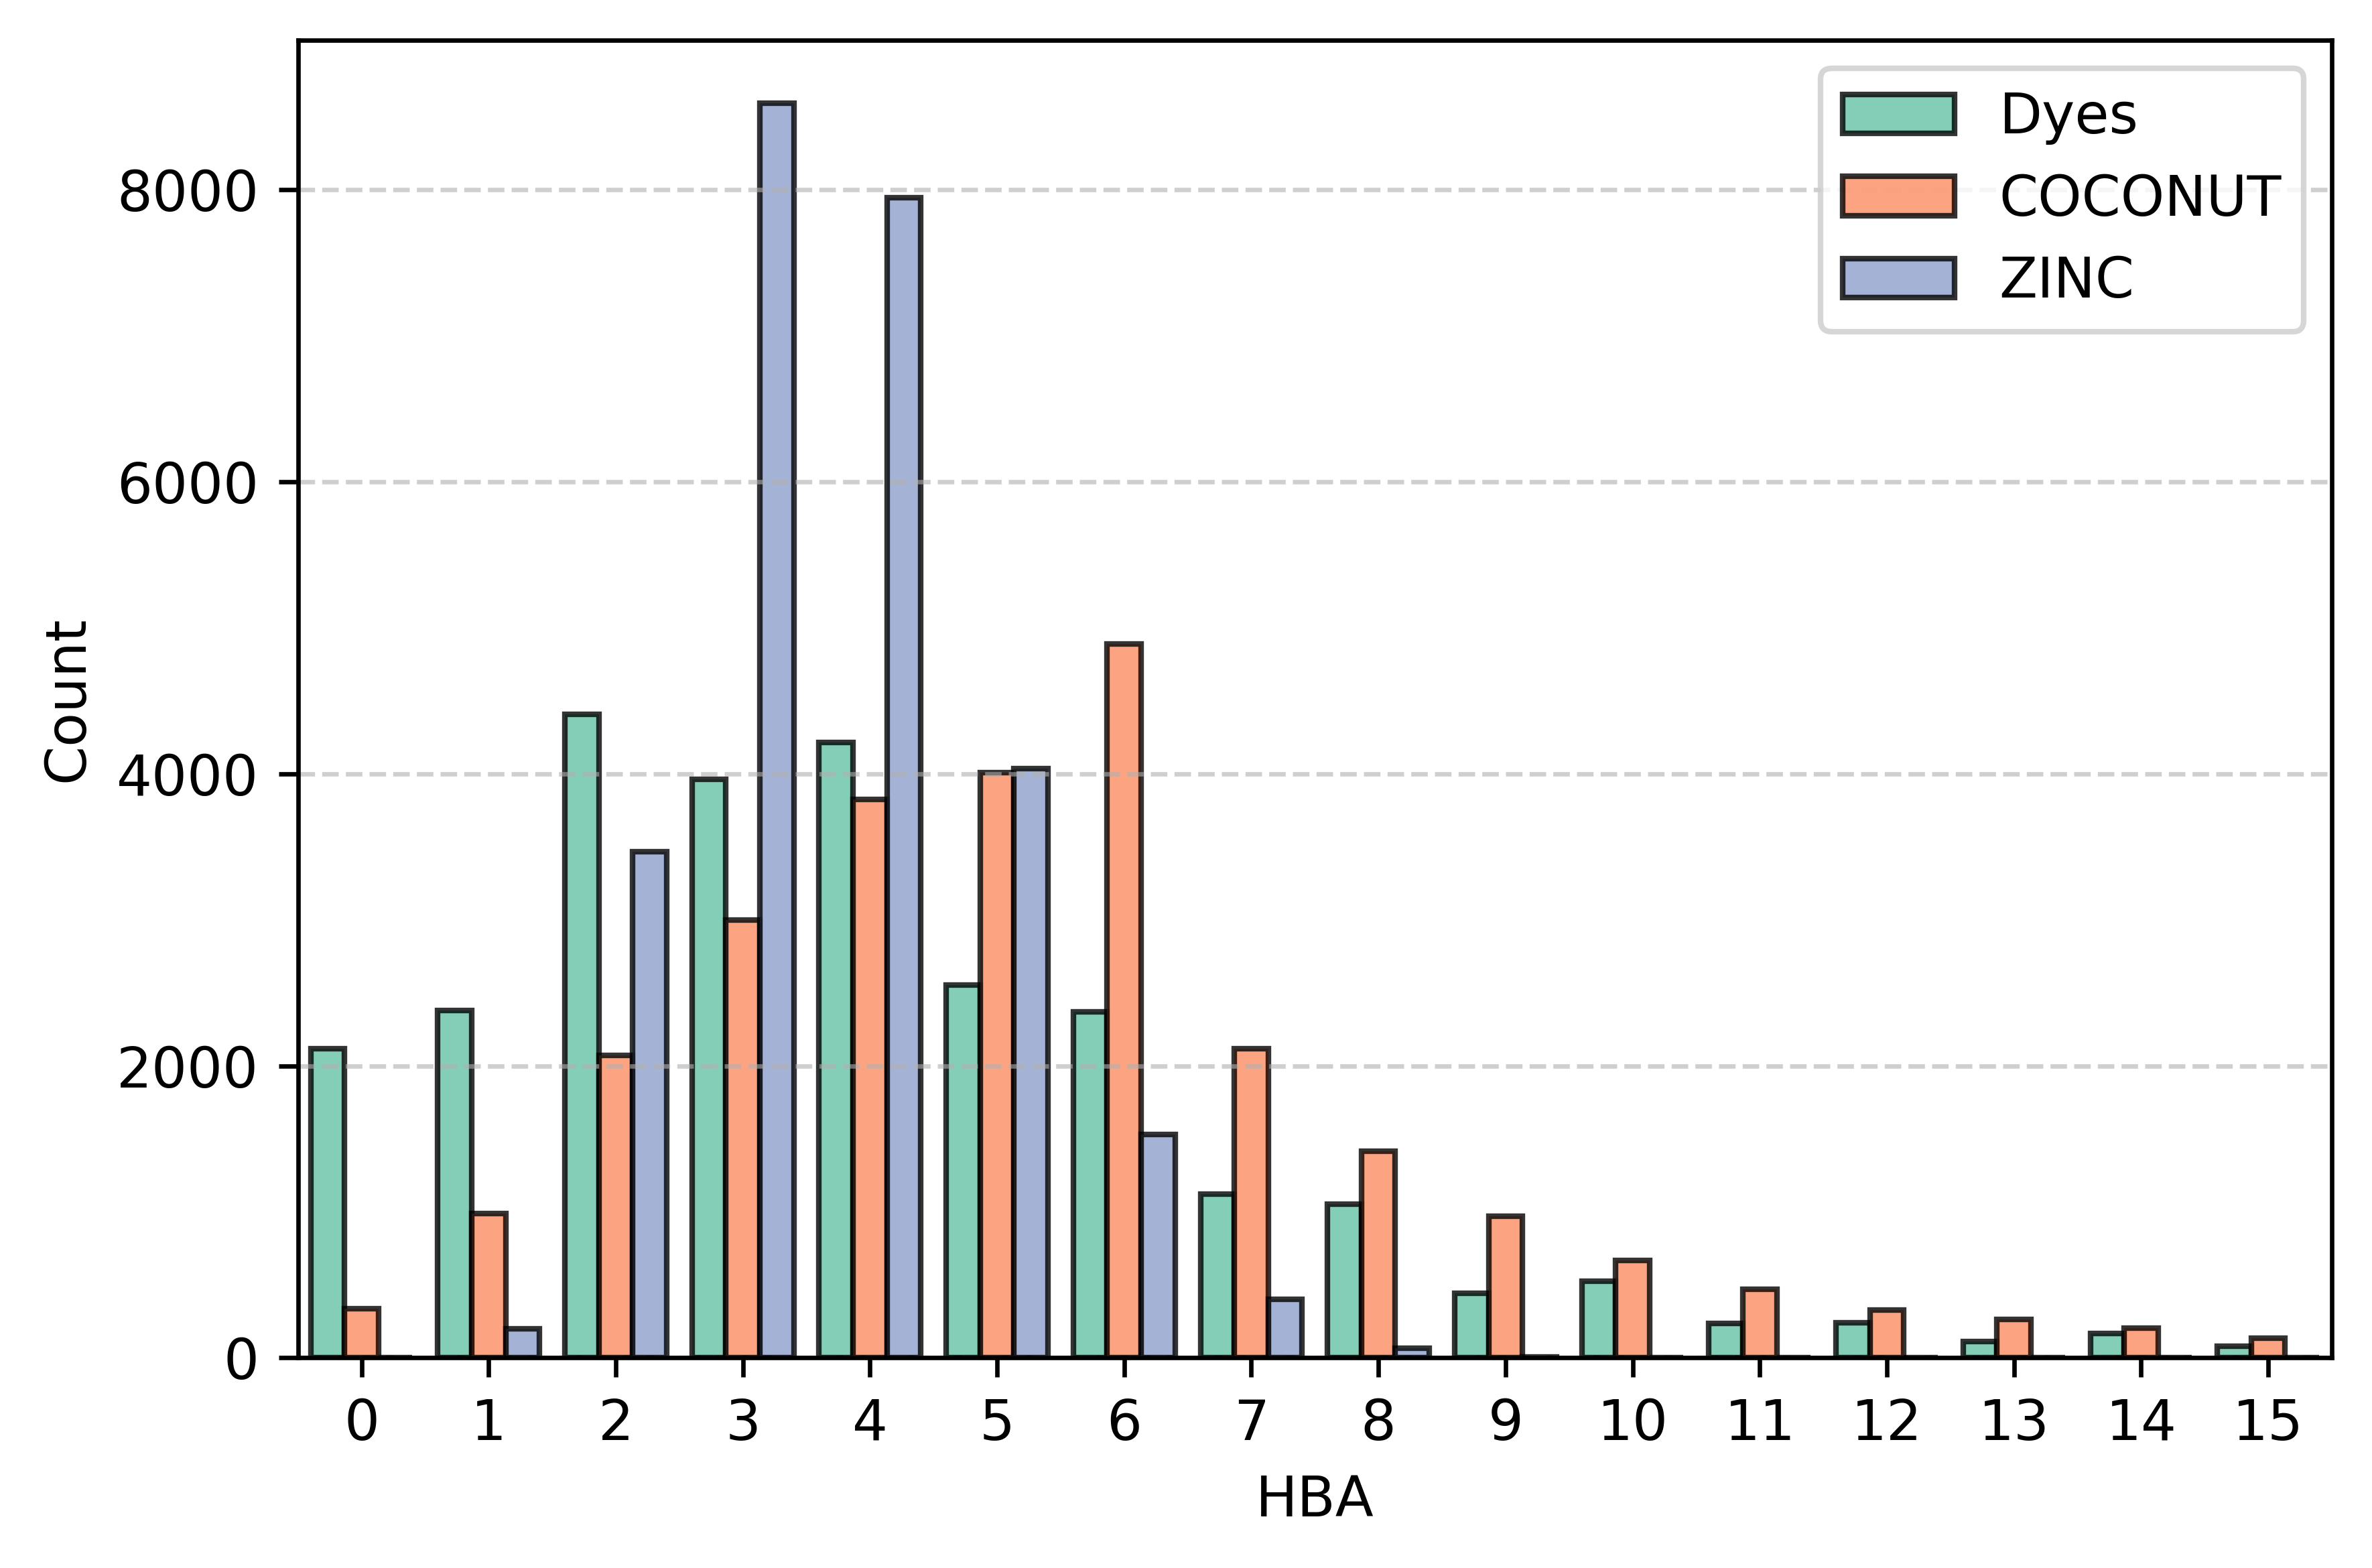

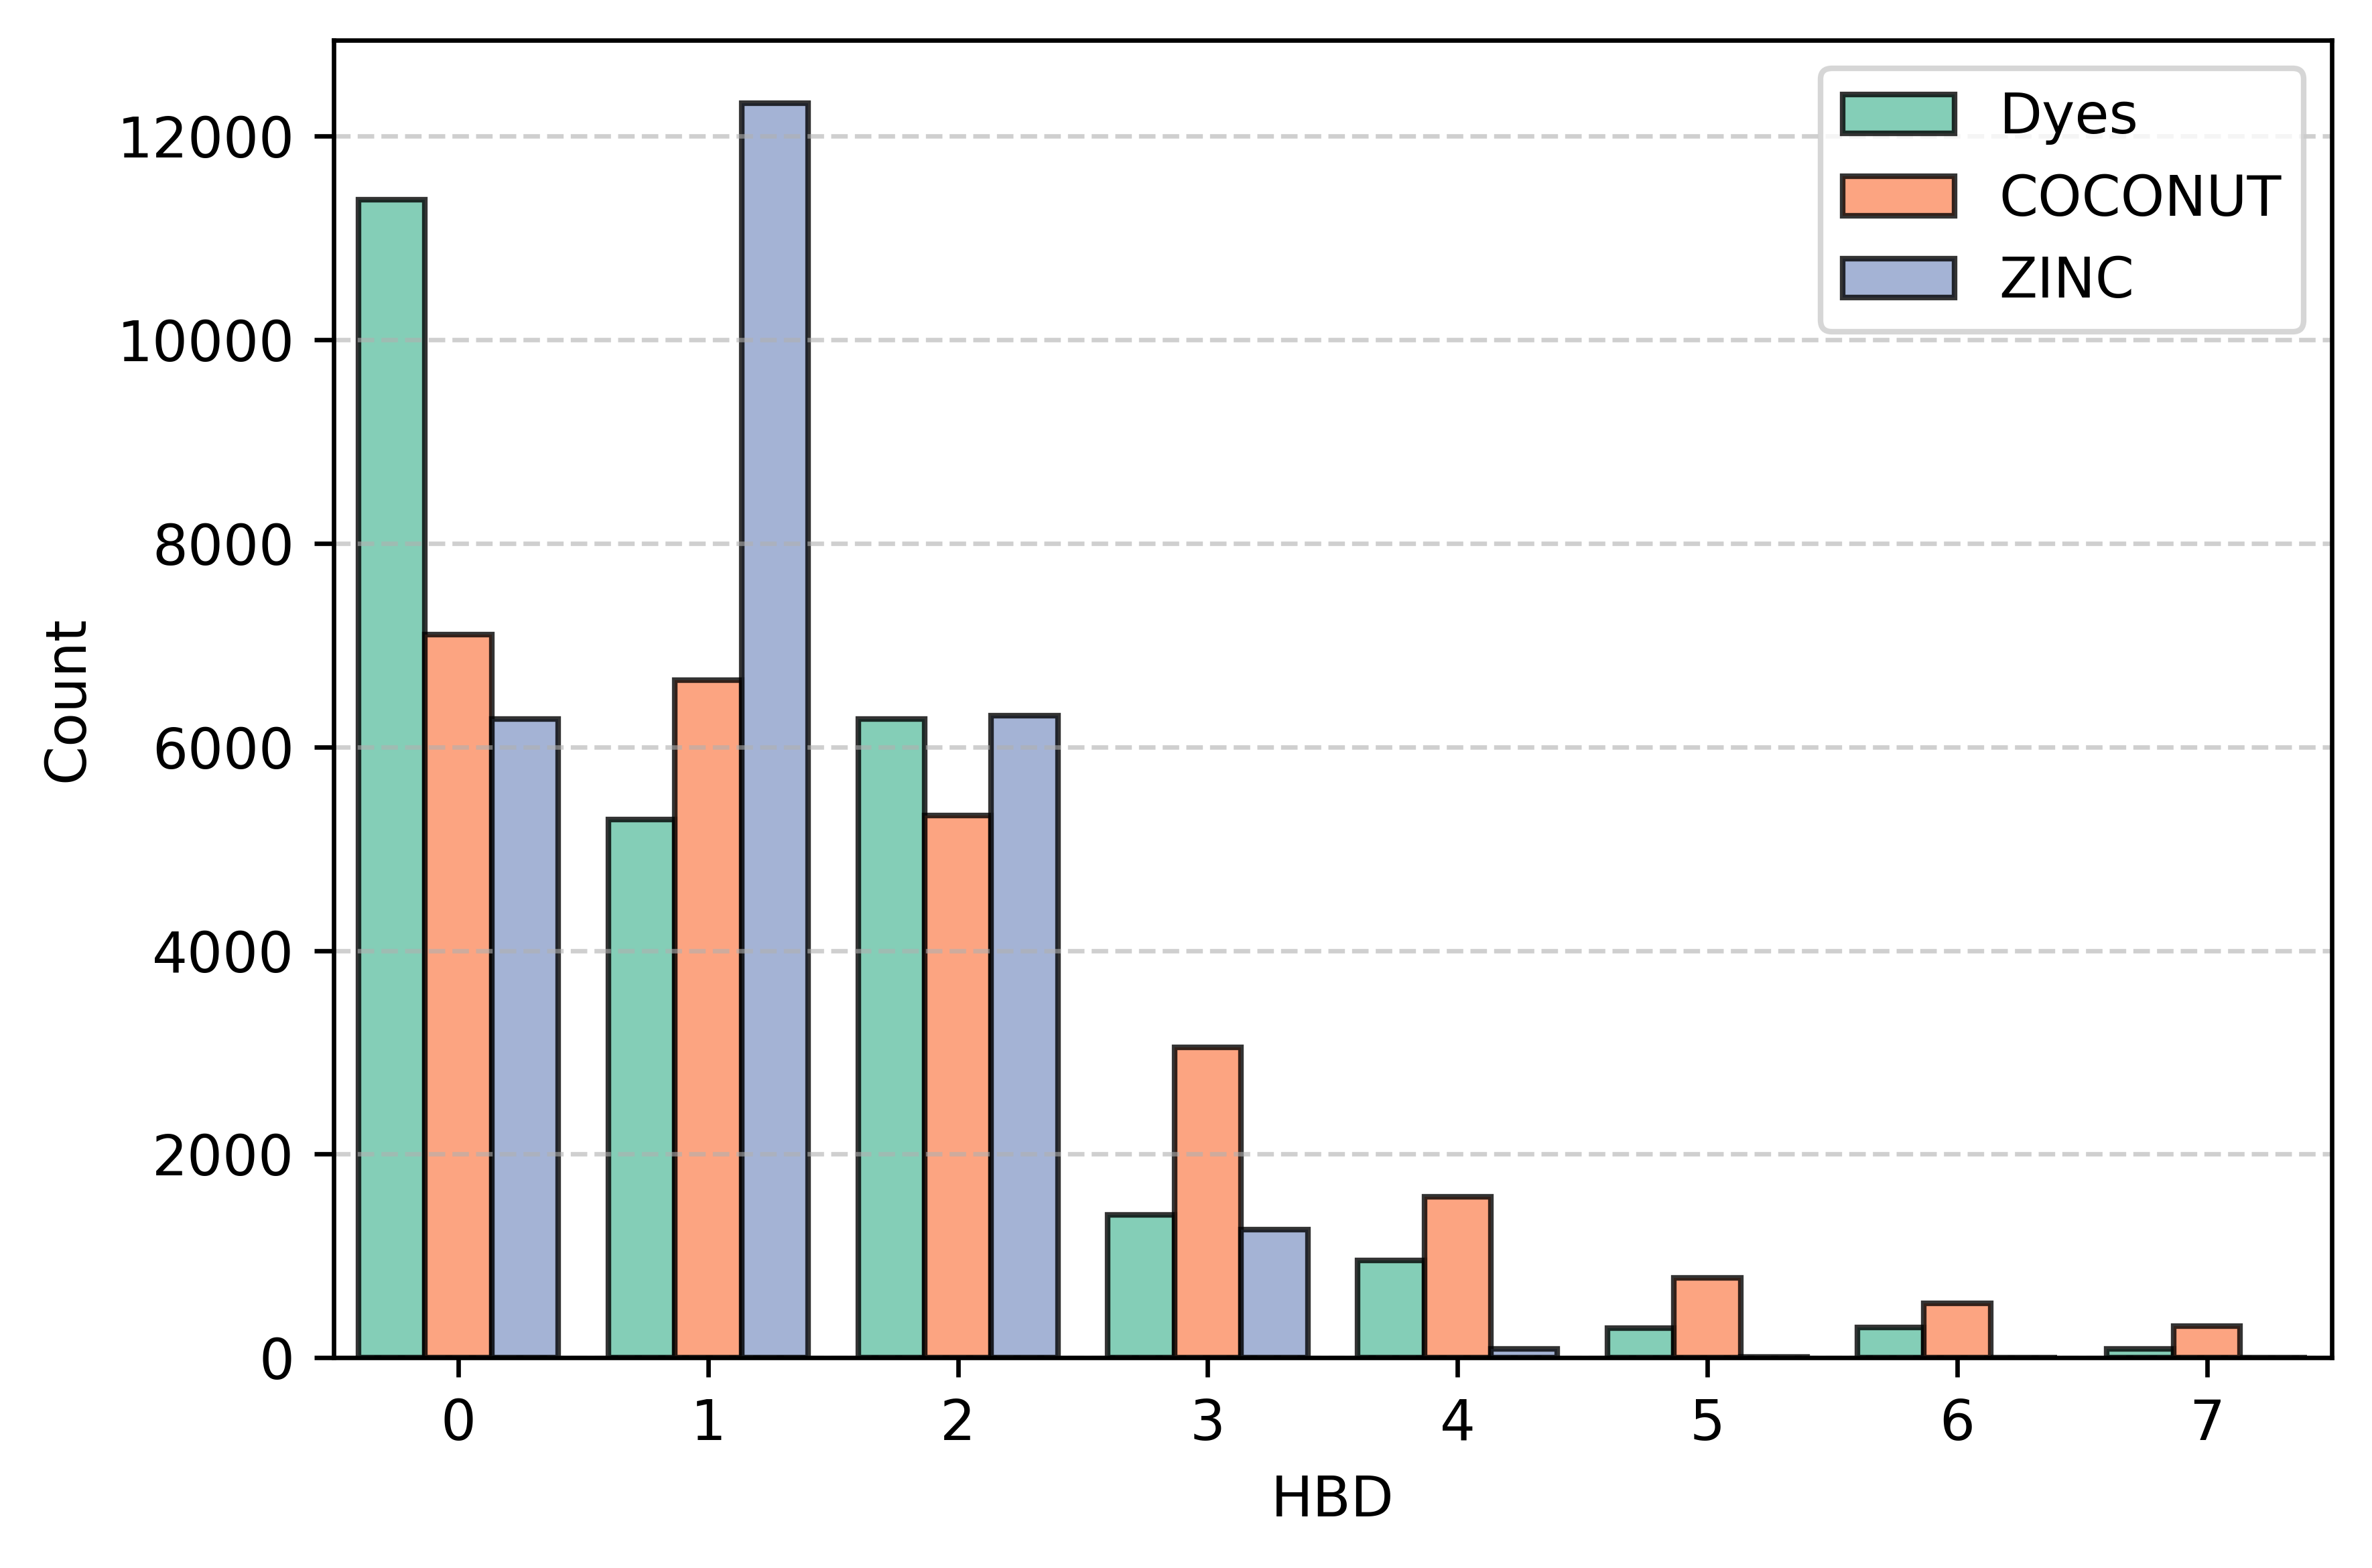

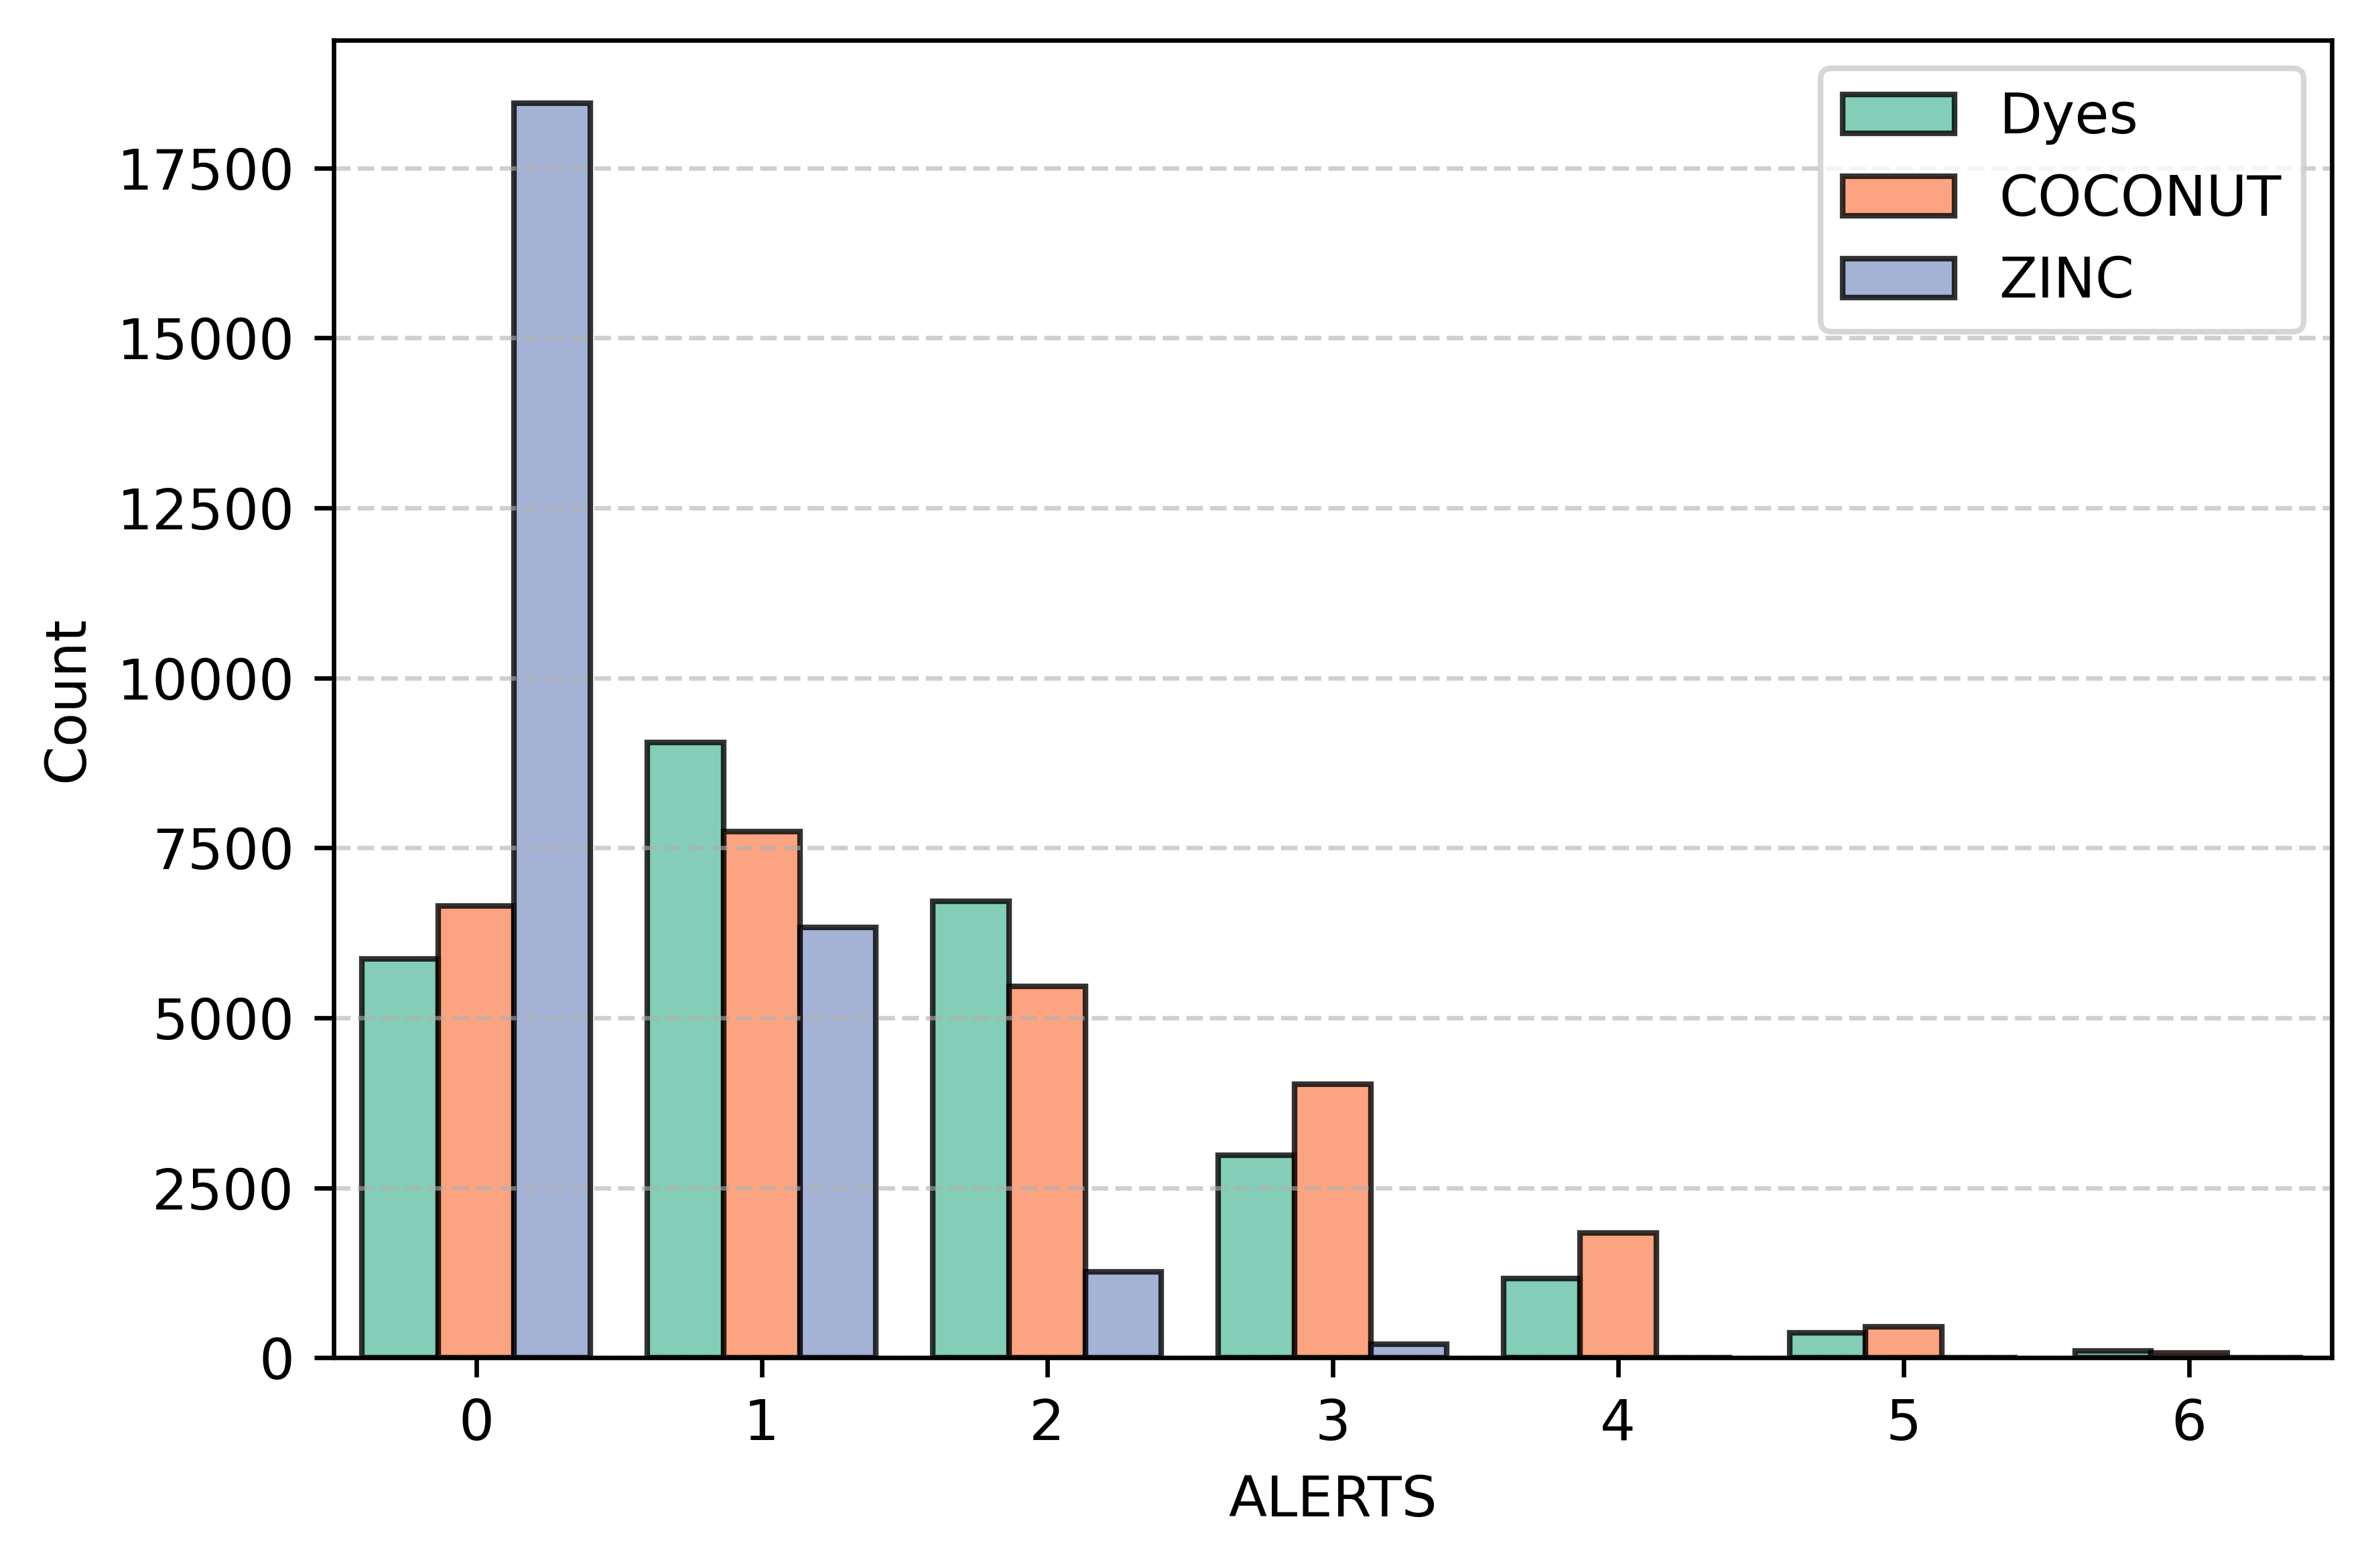

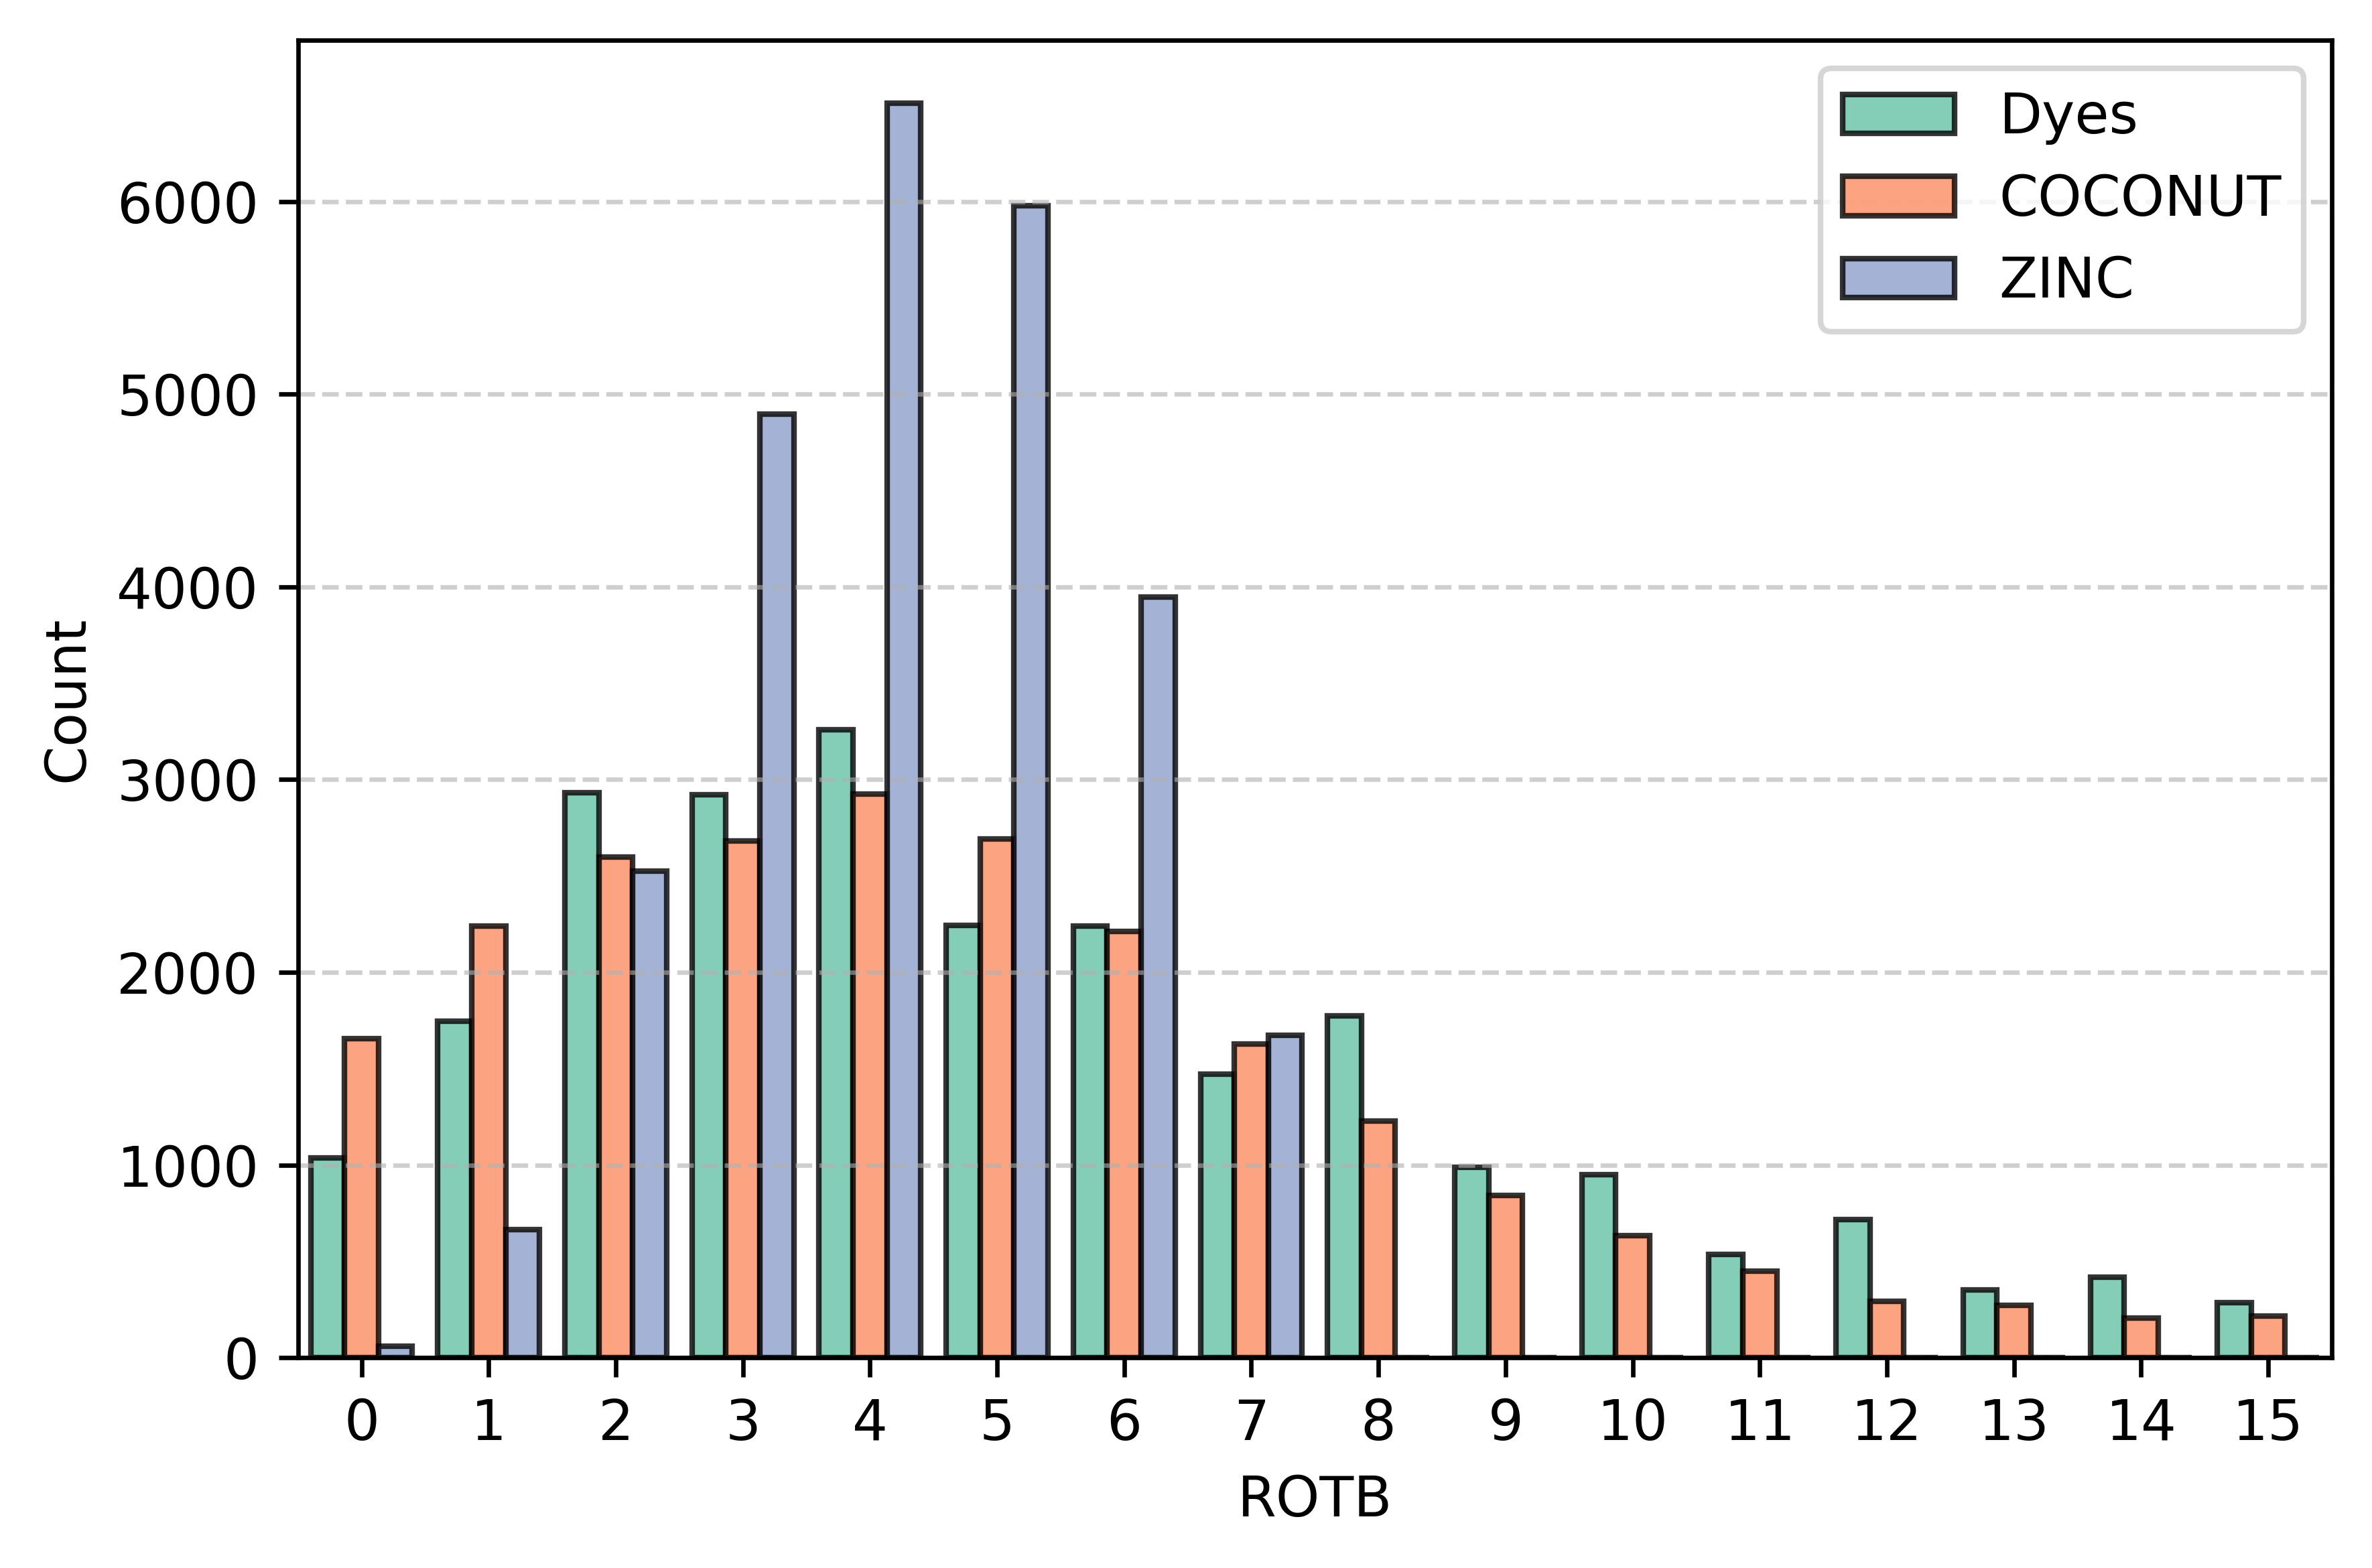

In [77]:
plot_discrete_distribution(dyes_df, coconut_df, zinc_df, "Dyes", "COCONUT", "ZINC", "HBA")
plot_discrete_distribution(dyes_df, coconut_df, zinc_df, "Dyes", "COCONUT", "ZINC", "HBD")
plot_discrete_distribution(dyes_df, coconut_df, zinc_df, "Dyes", "COCONUT", "ZINC", "ALERTS")
plot_discrete_distribution(dyes_df, coconut_df, zinc_df, "Dyes", "COCONUT", "ZINC", "ROTB")

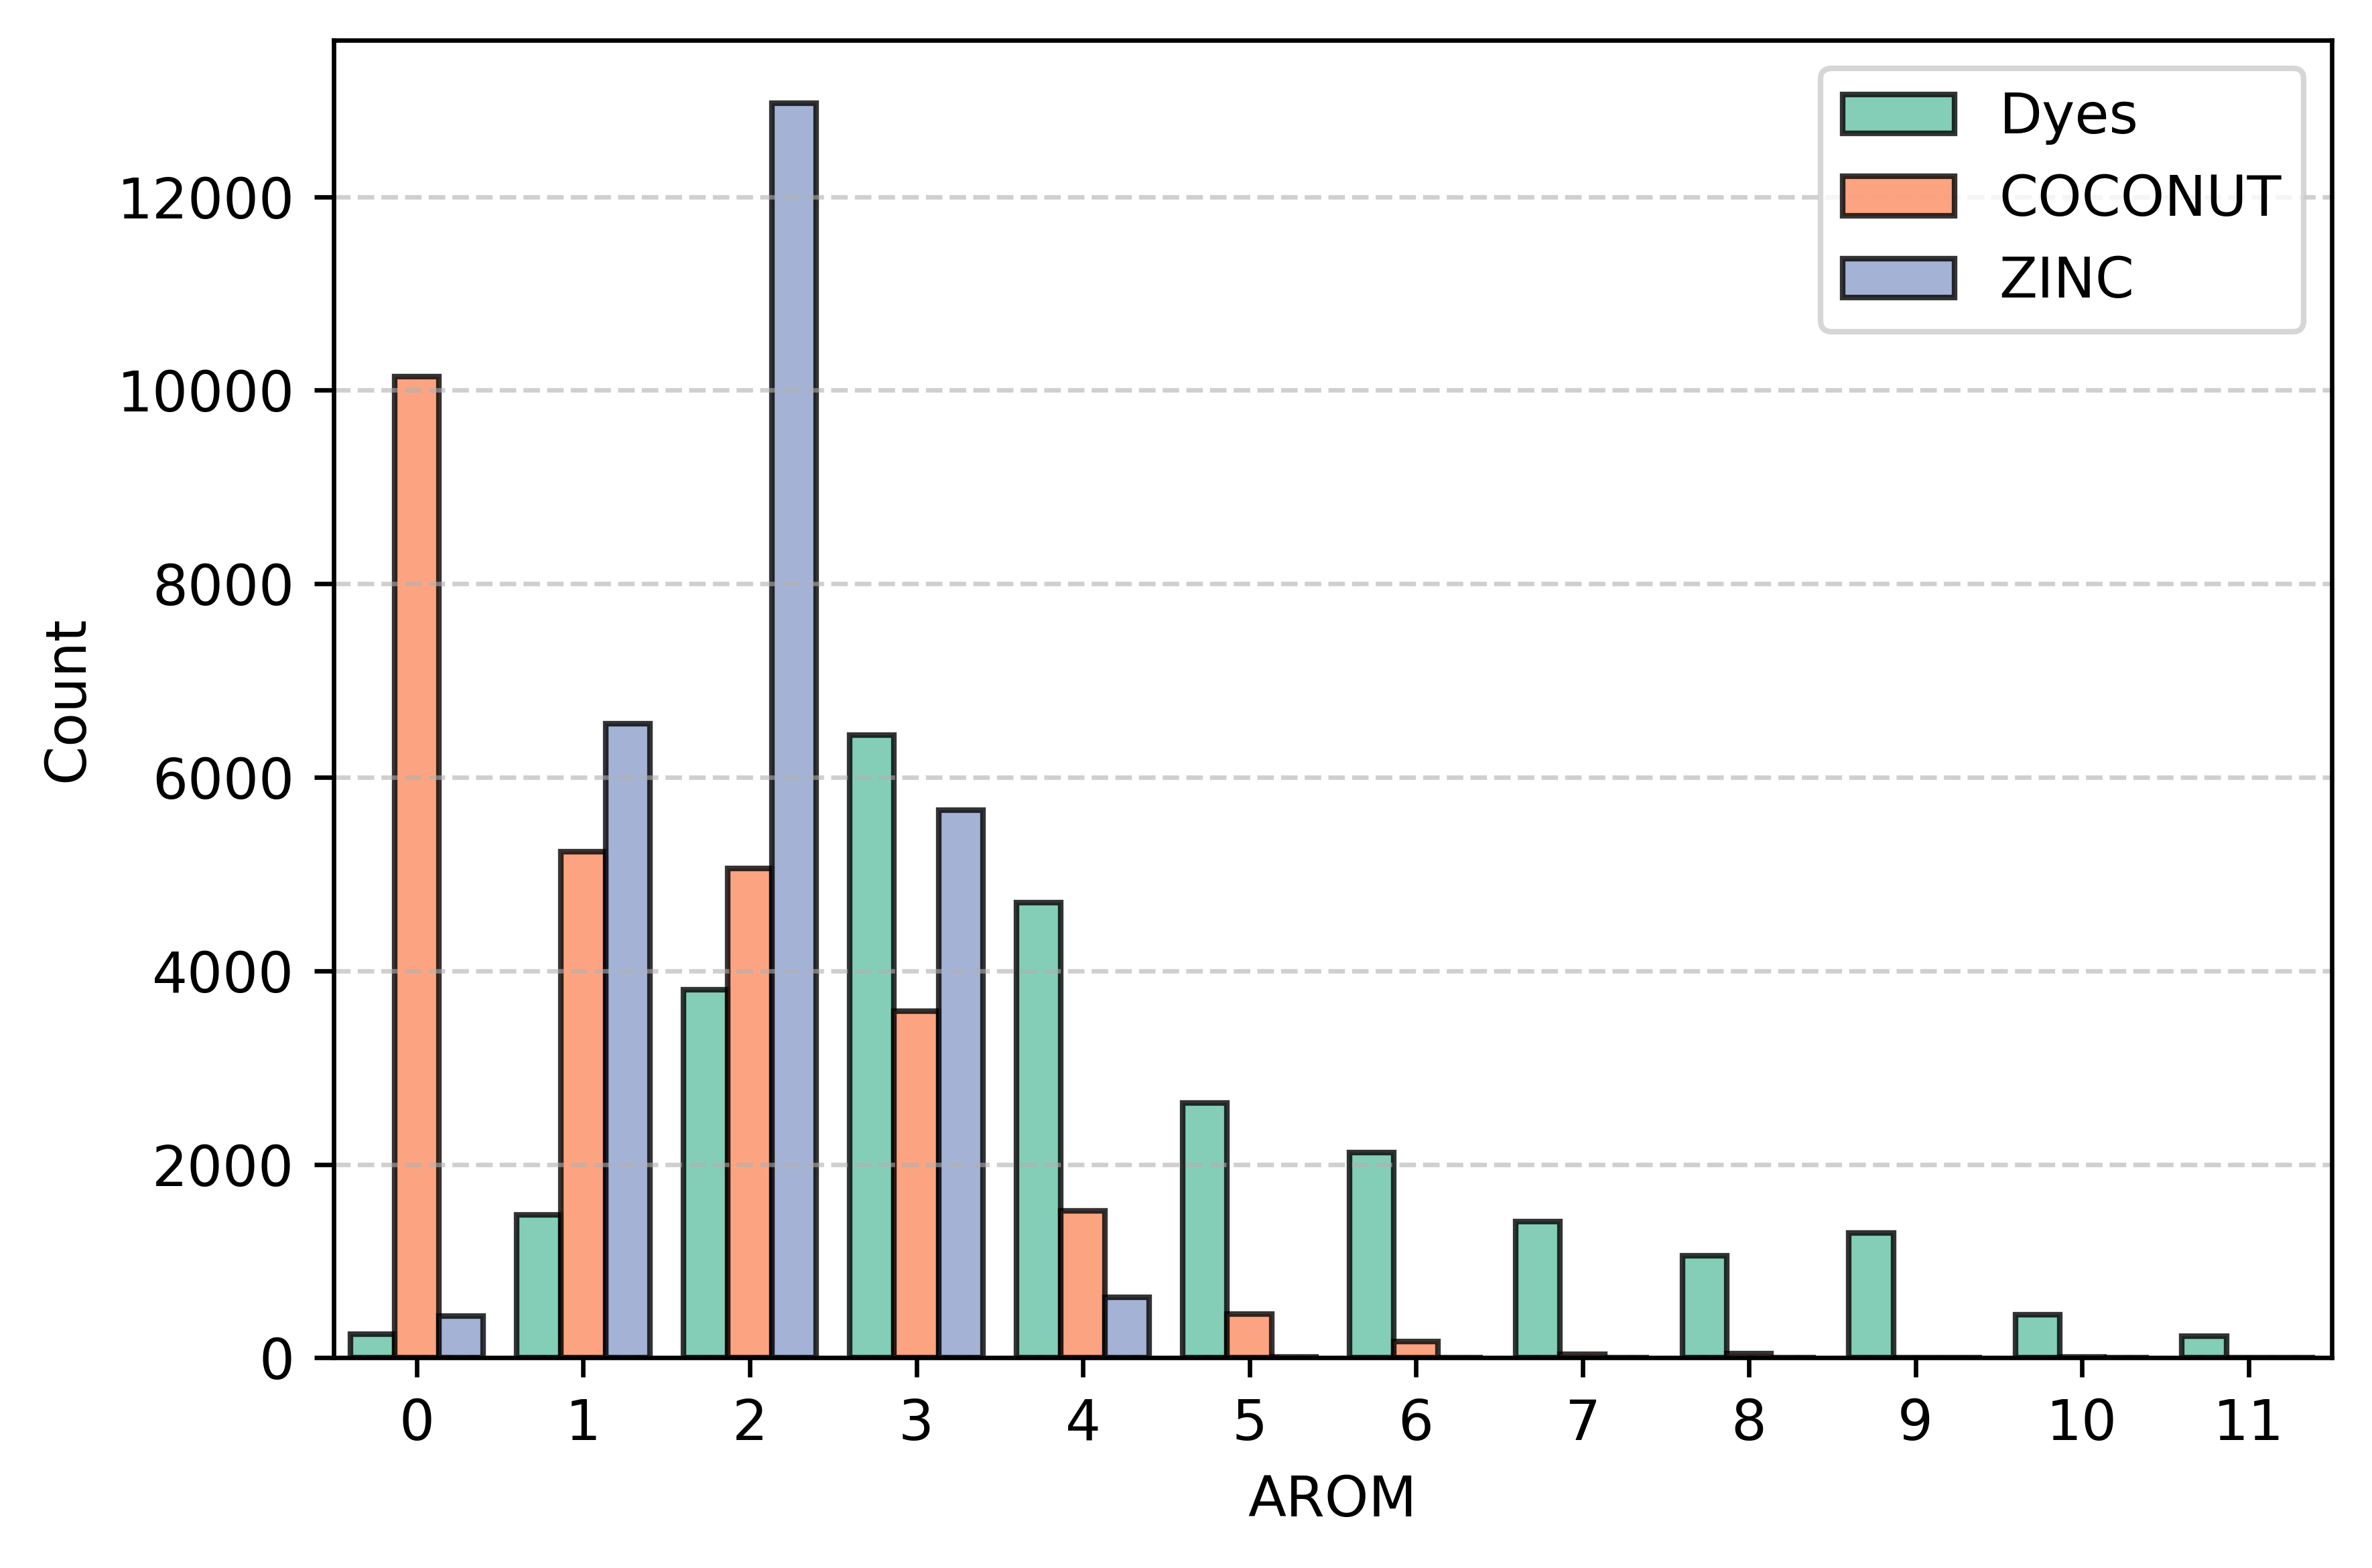

In [78]:
plot_discrete_distribution(dyes_df, coconut_df, zinc_df, "Dyes", "COCONUT", "ZINC", "AROM")